# Exploring Page Rank Nibble (Untiled and Runtime Incremental Tiling)

First, include some libraries

In [1]:
# Run boilerplate code to set up environment

%run ../prelude.py

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate Coordinate Range Fiber

In [2]:
def TileFiber_d(tileID, tileSize):
    return Fiber(coords=[d0 for d0 in range(tileID*tileSize, (tileID+1)*tileSize)], initial=1 )

#  Create Random Matrix


In [3]:
import random 

random.seed(0)
def GenerateRandomGraph(numVertex=8, sparsity=25, symmetric=True):
    adjMatrix = [[0 for d in range(numVertex)] for s in range(numVertex)]
    
    genNode = int(numVertex * numVertex * sparsity / 100)
    
    for n in range(genNode):
        while True:
            src = random.randrange(numVertex)
            dst = random.randrange(numVertex)
            if src != dst:
                break
                
        adjMatrix[src][dst] = 1
        if symmetric:
            adjMatrix[dst][src] = 1
    
    return adjMatrix

# Create Random Frontier

In [4]:
import random 

random.seed(0)
def GenerateRandomFrontier(numVertex=8, frontierSize=8):
    frontier = [ 0 for v in range(numVertex) ]

    for n in range(frontierSize):
        while True:
            v = random.randrange(numVertex)
            if frontier[v] != 1:
                break
        frontier[v] = 1
        
    frontier = Tensor.fromUncompressed(["F"], frontier)
        
    return frontier

# Generate Graph Inputs

In [5]:
#
# Function to create graph inputs
#


# Create inputs based on the slides that Aamer used to do the initial SPMV mapping on Symphony
def create_inputs(display=True, numNode=8):
    # Adjacency matrix - Ranks "S" (source) and "D" (destination)

    matrix = GenerateRandomGraph(numNode, 25)
    adjMat = Tensor.fromUncompressed([ "S", "D"], matrix)

    # Vector
    srcData = Tensor.fromUncompressed([ "S" ], [ 100 for s in range(numNode) ])

    # Vector
    dstData = Tensor.fromUncompressed([ "D" ], [ 0 for d in range(numNode) ])
    
    if display:
        displayTensor(adjMat)

    if display:
        displayTensor(srcData)

    if display:
        displayTensor(dstData)

    return (dstData, adjMat, srcData)

# Naive Untiled Page Rank Nibble

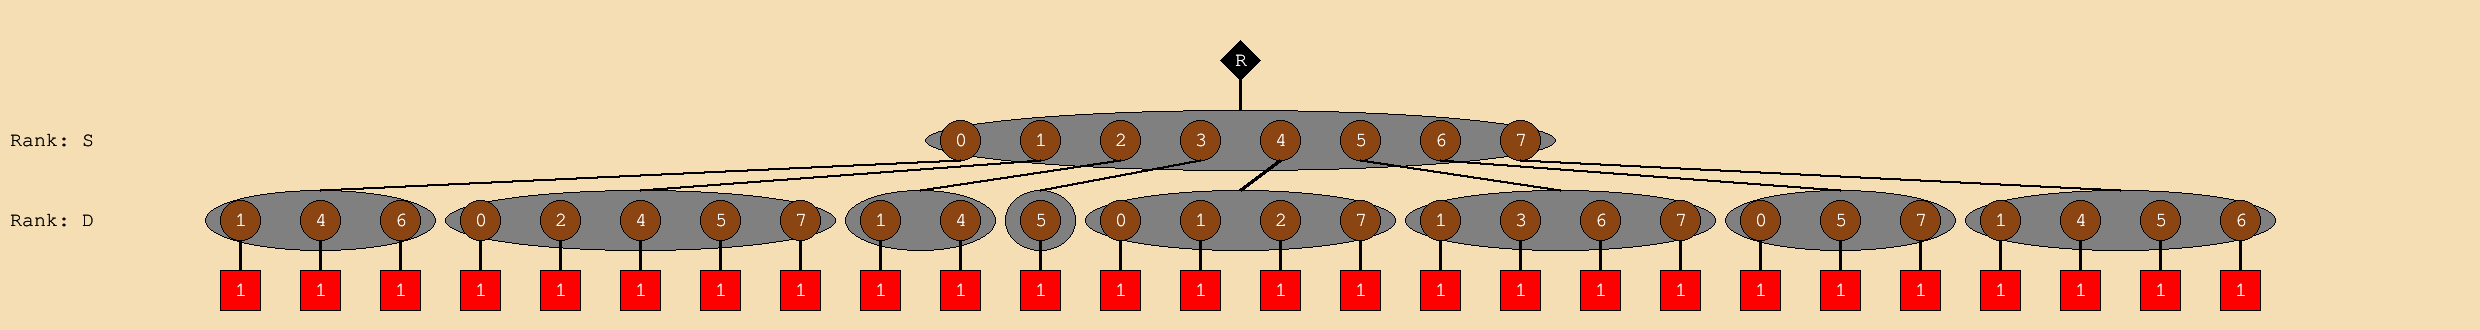

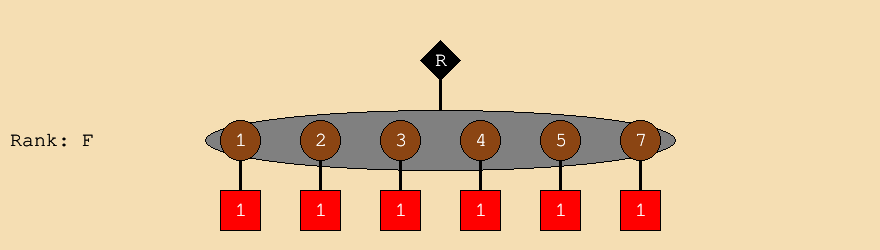

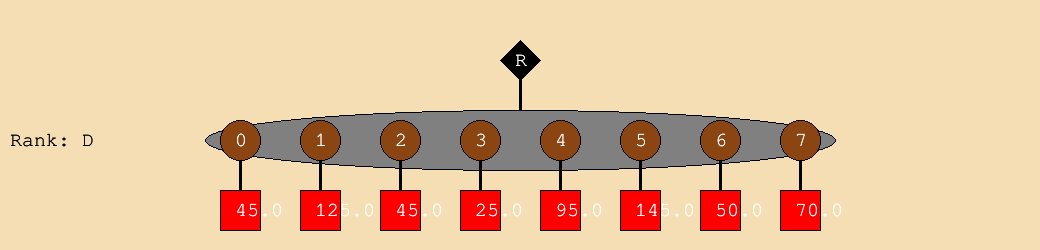

In [6]:
V  = 8

#Create inputs
(output, adjMat, input) = create_inputs(False, V)

#Create frontier
frontier = GenerateRandomFrontier(V, 6)

adjMat_s = adjMat.getRoot();
f_s      = frontier.getRoot();
input_v  = input.getRoot();
output_v = output.getRoot();

for s, ((adjMat_d, _), input_val) in ((adjMat_s & f_s) & input_v):
    degree   = len(adjMat_d)
    propVal  = input_val / degree
    for d, (output_ref, _), in (output_v << adjMat_d):
        output_ref += propVal

displayTensor(adjMat_s)
displayTensor(f_s)
displayTensor(output_v)

# Runtime Incremental Tiling

Tiling Parameters:
	V  =  8
	D0 =  4
	F0 =  2
	D1 =  2


Frontier: 


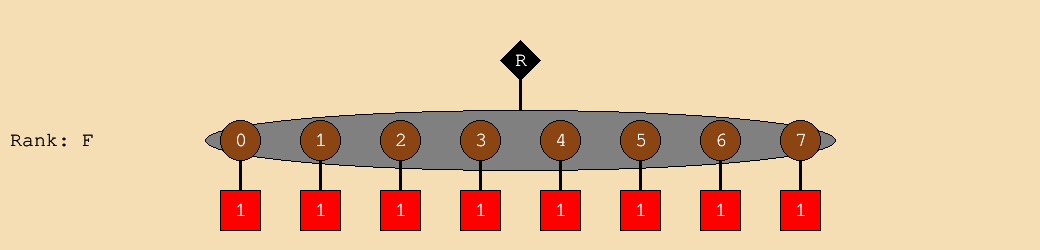



Frontier Split Equally: 


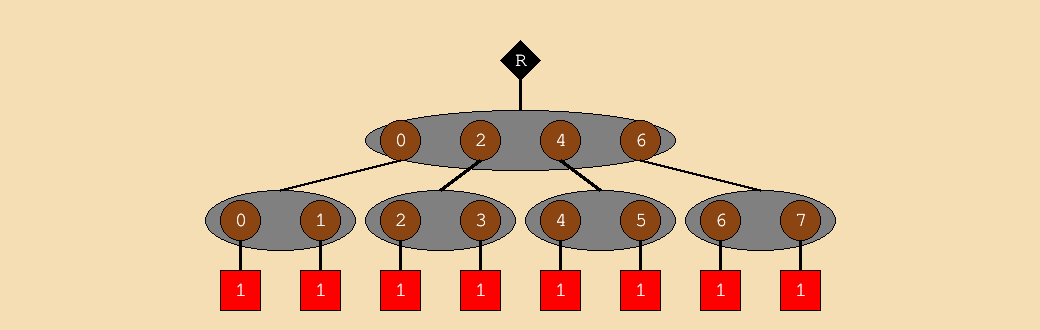



Graph: 


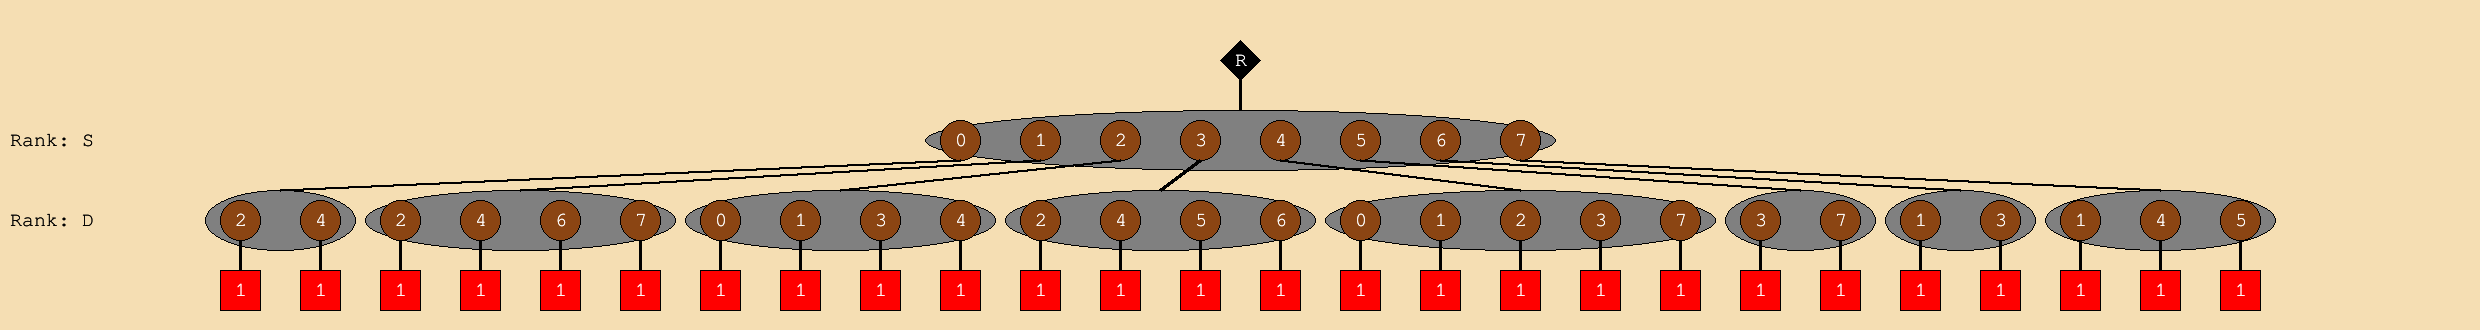



Processing: 


NameError: name 'GenFiber' is not defined

In [7]:
V  = 8
Fsize = V

F0 = 2
D0 = 4

print("Tiling Parameters:")
print("\tV  = ", V)
print("\tD0 = ", D0)
print("\tF0 = ", F0)

D1 = int((V/D0+1,V/D0) [(V%D0) == 0])

print("\tD1 = ", D1)

#Create inputs
(output, adjMat, input) = create_inputs(False, V)

#Create frontier
frontier = GenerateRandomFrontier(V, Fsize)

adjMat_s = adjMat.getRoot();
f_s      = frontier.getRoot();
input_v  = input.getRoot();
output_v = output.getRoot();

print("\n\nFrontier: ")
displayTensor(f_s)
frontier_split = f_s.splitEqual(F0)

print("\n\nFrontier Split Equally: ")
displayTensor(frontier_split)

print("\n\nGraph: ")
displayTensor(adjMat_s)

#print("\n\nAM HERE")
#tiler = [Fiber(coords=[d0 for d0 in range(d1*D0, (d1+1)*D0)], initial=1) for d1 in range(D1)]

#print("TILER: ", tiler)

# create a tensor frame
canvas = TensorCanvas(adjMat, input, output)

print("\n\nProcessing: ")
# for each equally split frontier tile
for f1, (fr_tile) in (frontier_split):
    
    # for each d1 tile
    for d1 in range(D1):
                
        # for each source (i.e., element of the frontier tile)
        for s, ((adjMat_d, _), input_val) in ((adjMat_s & fr_tile) & input_v):
            
            # determine the degree and the value to propogate
            degree   = len(adjMat_d)
            propVal  = input_val / degree

            # propagate for each destination (that belongs to the current d1 tile)
            for d, (output_ref, _), in (output_v << (adjMat_d & GenFiber(d1,D0))):
                canvas.addFrame([s,d], [s], [d])
                output_ref += propVal
                

print("\n\nGraph Output: ")
displayTensor(output_v)

displayCanvas(canvas)

In [ ]:
V  = 16
Fsize = 8

F0 = 2
F1 = 4

D0 = 4

print("Tiling Parameters:")
print("\tV  = ", V)
print("\tD0 = ", D0)
print("\tF0 = ", F0)

D1 = int((V/D0+1,V/D0) [(V%D0) == 0])

print("\tD1 = ", D1)

#Create inputs
(output, adjMat, input) = create_inputs(False, V)

#Create frontier
frontier = GenerateRandomFrontier(V, Fsize)

adjMat_s = adjMat.getRoot();
f_s      = frontier.getRoot();
input_v  = input.getRoot();
output_v = output.getRoot();

print("\n\nFrontier: ")
displayTensor(f_s)
frontier_s = f_s.splitEqual(F1)

print("\n\nFrontier Split Equally: ")
displayTensor(frontier_s)

frontier_s.splitEqualBelow(F0)
print("Frontier Split Twice:")
displayTensor(frontier_s)

canvas = TensorCanvas(adjMat, input, output)

AGGR_CNT = 4
aggrWork = [ [] for s in range(AGGR_CNT)]

myoutput = [0 for v in range(V)]

print("\n\nProcessing: ")

for f2, (F1_s) in (frontier_s):
    for d1 in range(D1):
        for f0, (F0_s) in (F1_s):

            # process sources (i.e., element of the frontier tile)
            for s, ((adjMat_d, _), input_val) in ((adjMat_s & F0_s) & input_v):

                # determine the degree and the value to propogate
                degree   = len(adjMat_d)
                propVal  = input_val / degree
                
                # queue up work to the appropriate aggregator
                for d, (_), in (adjMat_d & TileFiber_d(d1,D0)):
                    aggrID = d % AGGR_CNT
                    work = (d, propVal)
                    aggrWork[aggrID].append(work)
            
            # have the aggregators perform their work for the d1 tile
            for aggr in range(AGGR_CNT):
                for work in aggrWork[aggr]:
                    (d, propVal) = (work[0], work[1])
                    myoutput[d] += propVal
                    aggrWork[aggr].pop(0)

print("\n\nGraph Output: ")
displayTensor(output_v)

print("\n\nAggregator Work: ", aggrWork)
print("\n\nOutput: ", myoutput)

#displayCanvas(canvas)


# Runtime Incremental Tiling (Spatial and Temporal Tiling)

In [ ]:
V  = 16
Fsize = 8

F0 = 2
F1 = 4

D0 = 2

print("Tiling Parameters:")
print("\tV  = ", V)
print("\tD0 = ", D0)
print("\tF0 = ", F0)

D1 = int((V/D0+1,V/D0) [(V%D0) == 0])

print("\tD1 = ", D1)

#Create inputs
(output, adjMat, input) = create_inputs(False, V)

#Create the fiber pointers
fiberPtr = Tensor.fromUncompressed([ "S" ], [ 0 for s in range(V) ])

# create a workspace
work     = Tensor(V)

#Create frontier
frontier = GenerateRandomFrontier(V, Fsize)

adjMat_s = adjMat.getRoot();
f_s      = frontier.getRoot();
input_v  = input.getRoot();
output_v = output.getRoot();
fiberPtr_s = fiberPtr.getRoot();


print("\n\nFrontier: ")
displayTensor(f_s)
frontier_s = f_s.splitEqual(F1)

print("\n\nFrontier Split Equally: ")
displayTensor(frontier_s)

frontier_s.splitEqualBelow(F0)
print("Frontier Split Twice:")
displayTensor(frontier_s)

displayTensor(adjMat)

canvas = TensorCanvas(adjMat, input, output)

AGGR_CNT = 4
aggrWork = [ [] for s in range(AGGR_CNT)]

myoutput = [0 for v in range(V)]

print("\n\nProcessing: Aggr_Cnt: ", AGGR_CNT)
for f2, (F1_s) in (frontier_s):
    for d1 in range(D1):
        print("------------------------d1: ", d1, "----------------------------")
        for f0, (F0_s) in (F1_s):

            # process sources (i.e., element of the frontier tile)
            for s, (fiberPtr_ref, ((adjMat_d, _), input_val)) in (fiberPtr_s << ((adjMat_s & F0_s) & input_v)):

                # determine the degree and the value to propogate
                degree   = len(adjMat_d)
                propVal  = input_val / degree
        
        

                adjMat_D0 = adjMat_d.GetRange(d1*D0, D0, Shortcut_Start_Pos=fiberPtr_ref)
                fiberPtr_ref <<= adjMat_D0.Shortcut_End_Pos 
                
                for d, (output_ref, _) in (output_v<<adjMat_D0):
                    output_ref += propVal
                
                start    = int(fiberPtr_ref)
            
                for i in range(start, degree):
                    (d, adjmat_val) = adjMat_d[i]
                    if( int(d / D0) == d1 ):
                        print("s: ", s, " d1: ", d1, " Pos: ", fiberPtr_ref, " coord: ", adjMat_d[i])
                    else:
                        #print("fiber pointer of s: ", s, " is now: ", fiberPtr_ref)
                        break

                fiberPtr_ref += (i - start)
                print("fiber pointer of s: ", s, " is now: ", fiberPtr_ref)

                        
                # queue up work to the appropriate aggregator
                #for d, (_) in (adjMat_d):
                #    aggrID = d % AGGR_CNT
                #    work = (d, propVal)
                #    aggrWork[aggrID].append(work)
            
                # have the aggregators perform their work for the d1 tile
                #for aggr in range(AGGR_CNT):
                #    for work in aggrWork[aggr]:
                #        (d, propVal) = (work[0], work[1])
                #        myoutput[d] += propVal
                #    aggrWork[aggr].clear()
                    #print("Work In Aggregators: ", aggrWork)

print("\n\nGraph Output: ")
displayTensor(output_v)

print("\n\nAggregator Work: ", aggrWork)
print("\n\nOutput: ", myoutput)

#displayCanvas(canvas)